# Лабораторная работа 8

In [1]:
!pip install kaggle --quiet
!pip install -U ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00


In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/road-sign-detection
!unzip -q road-sign-detection.zip -d road-sign-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 84% 183M/218M [00:00<00:00, 335MB/s]
100% 218M/218M [00:00<00:00, 402MB/s]


In [6]:
import os
import xml.etree.ElementTree as ET
import shutil

dataset_dir = "road-sign-detection"
image_dir = os.path.join(dataset_dir, "images")
annotation_dir = os.path.join(dataset_dir, "annotations")

output_path = "road-sign-yolo"
os.makedirs(f"{output_path}/images/train", exist_ok=True)
os.makedirs(f"{output_path}/images/val", exist_ok=True)
os.makedirs(f"{output_path}/labels/train", exist_ok=True)
os.makedirs(f"{output_path}/labels/val", exist_ok=True)

classes = ["crosswalk", "stop", "speedlimit", "trafficlight"]
class_dict = {name: i for i, name in enumerate(classes)}

image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
split_idx = int(len(image_files) * 0.8)
train_imgs = image_files[:split_idx]
val_imgs = image_files[split_idx:]

def convert_bbox(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

def convert_annotation(image_name, subset):
    image_id = os.path.splitext(image_name)[0]
    xml_path = os.path.join(annotation_dir, f"{image_id}.xml")
    if not os.path.exists(xml_path):
        return

    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)

    out_file = open(f"{output_path}/labels/{subset}/{image_id}.txt", "w")
    for obj in root.iter("object"):
        cls = obj.find("name").text.strip()
        if cls not in class_dict:
            continue
        cls_id = class_dict[cls]
        xmlbox = obj.find("bndbox")
        b = [int(xmlbox.find("xmin").text), int(xmlbox.find("xmax").text),
             int(xmlbox.find("ymin").text), int(xmlbox.find("ymax").text)]
        bb = convert_bbox((w, h), b)
        out_file.write(f"{cls_id} {' '.join([str(round(a, 6)) for a in bb])}\n")
    out_file.close()

for subset, img_list in zip(["train", "val"], [train_imgs, val_imgs]):
    for img in img_list:
        shutil.copy(f"{image_dir}/{img}", f"{output_path}/images/{subset}/{img}")
        convert_annotation(img, subset)

yaml_path = os.path.join(output_path, "dataset.yaml")
with open(yaml_path, "w") as f:
    f.write(f"path: {output_path}\n")
    f.write("train: images/train\n")
    f.write("val: images/val\n")
    f.write("names:\n")
    for i, name in enumerate(classes):
        f.write(f"  {i}: {name}\n")


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

True
Tesla T4


In [5]:
def train_and_eval(weights, name, epochs, imgsz=640, lr=0.01,
                   batch=16, aug=None):
    model = YOLO(weights)
    results = model.train(data="road-sign-yolo/dataset.yaml",
                          epochs=epochs, imgsz=imgsz,
                          batch=batch, lr0=lr,
                          device=0,
                          save=True,
                          amp=True, seed=42,
                          **(aug or {}))
    val_res = model.val(data="road-sign-yolo/dataset.yaml", device=0)
    m50, m5095 = val_res.box.map50, val_res.box.map
    print(f"{name:14s} ➜ mAP50 {m50:.3f} | mAP50-95 {m5095:.3f}")
    return model, (m50, m5095)

# CNN (YOLO)

In [9]:
from ultralytics import YOLO

y11n, metrics_y11n = train_and_eval('yolov11n.pt', 'y11n_baseline',
                                  epochs=12, batch=32, lr=0.01)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 127MB/s]

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=road-sign-yolo/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False, save=

100%|██████████| 755k/755k [00:00<00:00, 21.5MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    752092  ultralytics.nn.modules.head.Detect           [4, [64, 128, 256]]           
Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 89.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1374.5±854.8 MB/s, size: 262.4 KB)


train: Scanning /content/road-sign-yolo/labels/train... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<00:00, 1293.96it/s]

train: New cache created: /content/road-sign-yolo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 709.9±739.5 MB/s, size: 209.1 KB)


val: Scanning /content/road-sign-yolo/labels/val... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<00:00, 418.15it/s]

val: New cache created: /content/road-sign-yolo/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12      4.14G     0.7625      2.944     0.9548         75        640: 100%|██████████| 22/22 [00:16<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

                   all        176        261    0.00345      0.651      0.426      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12      4.92G     0.7505      1.524     0.9301         66        640: 100%|██████████| 22/22 [00:13<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all        176        261          1      0.159      0.438      0.348


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12      4.94G     0.7135      1.568     0.9089         36        640: 100%|██████████| 22/22 [00:16<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        176        261      0.907      0.236      0.674      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12      4.96G     0.7151      1.443     0.9106         35        640: 100%|██████████| 22/22 [00:11<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        176        261      0.692      0.596      0.677       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      4.97G     0.7084      1.323     0.9107         36        640: 100%|██████████| 22/22 [00:12<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        176        261      0.675      0.704      0.718      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12      4.99G     0.6932      1.172     0.9007         38        640: 100%|██████████| 22/22 [00:12<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all        176        261      0.839      0.736      0.806      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      5.01G      0.664      1.063     0.8953         37        640: 100%|██████████| 22/22 [00:12<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all        176        261      0.917      0.701        0.8      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12      5.02G     0.6382      0.975     0.8824         36        640: 100%|██████████| 22/22 [00:12<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


                   all        176        261      0.886      0.815       0.88      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12      5.04G      0.625      0.895     0.8778         41        640: 100%|██████████| 22/22 [00:11<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        176        261      0.845      0.819      0.872      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12      5.06G     0.5909     0.8201     0.8674         38        640: 100%|██████████| 22/22 [00:12<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        176        261      0.924      0.823      0.869      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12      5.08G     0.5807      0.777     0.8666         38        640: 100%|██████████| 22/22 [00:12<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all        176        261      0.901      0.847      0.898      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12      5.09G     0.5484     0.7209     0.8446         43        640: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        176        261      0.931       0.83      0.894      0.736



12 epochs completed in 0.056 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


                   all        176        261      0.933      0.831      0.895      0.736
             crosswalk         34         40      0.972      0.867      0.929      0.744
                  stop         23         23      0.949      0.816      0.926      0.816
            speedlimit        128        154      0.971      0.981      0.987      0.865
          trafficlight         26         44      0.838      0.659      0.736      0.519
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 8.1ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3962.2±977.5 MB/s, size: 302.1 KB)


val: Scanning /content/road-sign-yolo/labels/val.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


                   all        176        261      0.933      0.831      0.895      0.737
             crosswalk         34         40      0.972      0.867      0.929      0.742
                  stop         23         23      0.949      0.816      0.926       0.82
            speedlimit        128        154      0.971      0.981      0.987      0.866
          trafficlight         26         44      0.838      0.659      0.736       0.52
Speed: 4.9ms preprocess, 4.5ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train2
y11n_baseline   ➜ mAP50 0.895 | mAP50-95 0.737



image 1/1 /content/road-sign-yolo/images/val/road247.png: 640x480 2 speedlimits, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


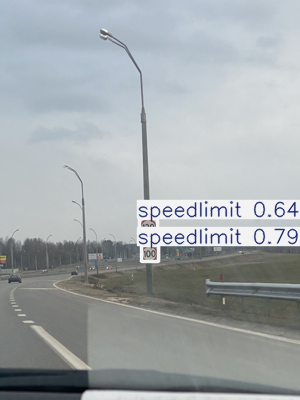

In [ ]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO('runs/detect/train/weights/best.pt')
image_path = 'road-sign-yolo/images/val/road247.png'
results = model(image_path)
results[0].show()

# Улучшение бейзлайна

Гипотезы:
1. Изменение оттенка, насыщенности и яркости помогает модели стать устойчивее к различиям в цветовой гамме изображений, что полезно при обучении на датасетах с разнообразным освещением и стилями;

2. Афинные преобразования позволяют модели научиться распознавать объекты независимо от их ориентации, положения и размера;

3. Перспективные искажения помогают улучшить устойчивость модели к изменениям точки обзора и перспективы, расширяя способность модели к обобщению;

4. Mosaic-аугментация увеличивает разнообразие контекстов, в которых появляются объекты, позволяя модели лучше распознавать мелкие объекты и работать в условиях плотной сцены;

5. MixUp способствует уменьшению переобучения за счёт регуляризации: при смешивании изображений и меток модель обучается на промежуточных примерах, что улучшает её обобщающую способность;

6. Горизонтальное отражение с вероятностью 50% увеличивает разнообразие тренировочных данных, позволяя учитывать зеркальные варианты объектов и тем самым повышать устойчивость модели.

In [ ]:
strong_aug = dict(
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=15,
    translate=0.1, scale=0.7, shear=0.0, perspective=0.0005,
    mosaic=1.0, mixup=0.2, flipud=0.0, fliplr=0.5,
)

y11s, metrics_y11s = train_and_eval('yolov11s.pt', 'y11s_strong',
                                  epochs=12, batch=32,
                                  lr=0.01, aug=strong_aug)

100%|██████████| 21.5M/21.5M [00:00<00:00, 190MB/s]


Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=road-sign-yolo/dataset.yaml, degrees=15, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0005, plots=True, pose=12.0, pretrained=

train: Scanning /content/road-sign-yolo/labels/train.cache... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1449.2±876.6 MB/s, size: 209.1 KB)


val: Scanning /content/road-sign-yolo/labels/val.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12       6.9G      1.422      4.174      1.377         85        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

                   all        176        261      0.798      0.573      0.786       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12      6.83G      1.082      1.292      1.181         90        640: 100%|██████████| 22/22 [00:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all        176        261      0.632      0.696      0.613      0.371


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12      6.88G     0.9927      1.194      1.159         36        640: 100%|██████████| 22/22 [00:19<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        176        261      0.803      0.554      0.619      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12      6.88G     0.9872     0.9947      1.169         35        640: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        176        261        0.6      0.342      0.414      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      6.87G      0.953     0.8681      1.152         36        640: 100%|██████████| 22/22 [00:16<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        176        261      0.785      0.488      0.533      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12      6.88G     0.8799     0.7868      1.108         38        640: 100%|██████████| 22/22 [00:15<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        176        261      0.735      0.592      0.607      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      6.88G     0.8505     0.7197      1.101         37        640: 100%|██████████| 22/22 [00:15<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        176        261      0.907      0.655      0.738      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12      6.88G     0.8459     0.6671      1.098         36        640: 100%|██████████| 22/22 [00:15<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        176        261       0.85      0.785      0.839       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12      6.88G      0.815     0.6336      1.089         41        640: 100%|██████████| 22/22 [00:15<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

                   all        176        261      0.884      0.772      0.846      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12      6.88G     0.7503     0.5763      1.027         38        640: 100%|██████████| 22/22 [00:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all        176        261      0.903      0.835      0.884      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12      6.87G     0.7338     0.5267     0.9959         38        640: 100%|██████████| 22/22 [00:16<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

                   all        176        261      0.903      0.835      0.896      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12      6.88G     0.6908     0.4884     0.9908         43        640: 100%|██████████| 22/22 [00:15<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        176        261      0.916      0.857      0.917      0.685



12 epochs completed in 0.070 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


                   all        176        261      0.916      0.857      0.917      0.685
             crosswalk         34         40      0.925      0.921      0.933      0.721
                  stop         23         23      0.947      0.776      0.959      0.766
            speedlimit        128        154      0.991      0.981       0.99      0.806
          trafficlight         26         44      0.802       0.75      0.785      0.448
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/detect/train3
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3111.7±1200.3 MB/s, size: 302.1 KB)


val: Scanning /content/road-sign-yolo/labels/val.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


                   all        176        261      0.875      0.895      0.917      0.685
             crosswalk         34         40       0.89      0.925      0.934      0.723
                  stop         23         23      0.907      0.852       0.96      0.766
            speedlimit        128        154      0.981      0.984       0.99      0.806
          trafficlight         26         44      0.721       0.82      0.784      0.446
Speed: 2.7ms preprocess, 8.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train32
y11s_strong     ➜ mAP50 0.917 | mAP50-95 0.685



image 1/1 /content/road-sign-yolo/images/val/road247.png: 640x480 2 speedlimits, 12.5ms
Speed: 3.3ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


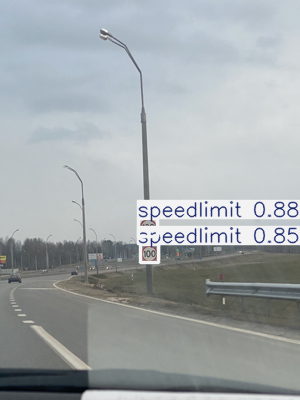

In [29]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO('runs/detect/train3/weights/best.pt')
image_path = 'road-sign-yolo/images/val/road247.png'
results = model(image_path)
results[0].show()


## Сравнение результатов с обычным бейзлайном

По результатам оценки качества моделей с применением улучшенного подхода наблюдается следующий прирост:

1. mAP@50 увеличился с 0.895 до 0.917, что свидетельствует о более точной локализации объектов;

2. mAP@50-95 уменьшился с 0.737 до 0.685, что может указывать на снижение качества при более строгих порогах IoU, возможно из-за недостаточной устойчивости модели к мелким или частично перекрытым объектам.

## Выводы

* Внесённые улучшения положительно сказались на метрике mAP@50, что особенно важно для задач, где важна уверенная детекция объектов;

* Снижение mAP@50-95 указывает на то, что модель хуже справляется с точной локализацией при более высоких требованиях, возможно из-за агрессивных аугментаций или недостаточной адаптации модели;

# Имплементация алгоритма машинного обучения 

In [54]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import xml.etree.ElementTree as ET
from collections import Counter

def build_class_to_idx(annotations_dir):
    classes = set()

    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            xml_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)

    classes = sorted(list(classes))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    return class_to_idx

annotations_dir = '/content/road-sign-detection/annotations'
class_to_idx = build_class_to_idx(annotations_dir)
class_to_idx

{'crosswalk': 0, 'speedlimit': 1, 'stop': 2, 'trafficlight': 3}

In [51]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import xml.etree.ElementTree as ET

class RoadSignDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, class_to_idx, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        annot_path = os.path.join(self.annotations_dir, img_filename.replace('.png', '.xml'))

        image = Image.open(img_path).convert('RGB')

        orig_w, orig_h = image.size

        boxes, labels = self.parse_annotation(annot_path)

        if self.transform:
            image = self.transform(image)

        new_h, new_w = image.shape[1], image.shape[2]

        boxes = torch.tensor(boxes, dtype=torch.float32)
        scale_x = new_w / orig_w
        scale_y = new_h / orig_h
        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y

        labels = torch.tensor(labels, dtype=torch.long)

        target = {"boxes": boxes, "labels": labels}

        return image, target



    def parse_annotation(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            label = self.class_to_idx.get(name, -1)
            if label == -1:
                continue

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        return boxes, labels



In [52]:
import os
import shutil
import random

def split_dataset(base_dir, output_dir, train_ratio=0.8, val_ratio=0.2, seed=42):
    random.seed(seed)

    images_dir = os.path.join(base_dir, 'images')
    annotations_dir = os.path.join(base_dir, 'annotations')

    all_images = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    random.shuffle(all_images)

    total = len(all_images)
    train_end = int(total * train_ratio)

    train_files = all_images[:train_end]
    val_files = all_images[train_end:]

    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    for split in ['train', 'val']:
        images_split_dir = os.path.join(output_dir, split, 'images')
        annotations_split_dir = os.path.join(output_dir, split, 'annotations')

        for dir_path in [images_split_dir, annotations_split_dir]:
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)
            os.makedirs(dir_path, exist_ok=True)

    def copy_files(file_list, split_name):
        for filename in file_list:
            img_src = os.path.join(images_dir, filename)
            annot_src = os.path.join(annotations_dir, filename.replace('.png', '.xml'))

            img_dst = os.path.join(output_dir, split_name, 'images', filename)
            annot_dst = os.path.join(output_dir, split_name, 'annotations', filename.replace('.png', '.xml'))

            shutil.copy(img_src, img_dst)
            shutil.copy(annot_src, annot_dst)

    copy_files(train_files, 'train')
    copy_files(val_files, 'val')

split_dataset(
    base_dir='road-sign-detection',
    output_dir='road-sign-detection-split',
    train_ratio=0.8,
    val_ratio=0.2
)


Train: 701, Val: 176


In [55]:
transform = T.Compose([
    T.Resize((416, 416)),
    T.ToTensor(),
])
train_dataset = RoadSignDataset(
    images_dir='road-sign-detection-split/train/images',
    annotations_dir='road-sign-detection-split/train/annotations',
    class_to_idx=class_to_idx,
    transform=transform
)

val_dataset = RoadSignDataset(
    images_dir='road-sign-detection-split/val/images',
    annotations_dir='road-sign-detection-split/val/annotations',
    class_to_idx=class_to_idx,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [56]:
import torch
import torch.nn as nn

class TinyYOLOv3(nn.Module):
    def __init__(self, num_classes=4, anchors_26=2, anchors_13=2):
        super(TinyYOLOv3, self).__init__()

        def conv_bn_lrelu(in_channels, out_channels, kernel_size, stride=1):
            padding = (kernel_size - 1) // 2
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1)
            )

        self.layer1 = conv_bn_lrelu(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.layer2 = conv_bn_lrelu(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.layer3 = conv_bn_lrelu(32, 64, 3)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.layer4 = conv_bn_lrelu(64, 128, 3)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.layer5 = conv_bn_lrelu(128, 256, 3)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.layer6 = conv_bn_lrelu(256, 512, 3)
        self.pool6 = nn.MaxPool2d(2, 2, padding=1)

        self.layer7 = conv_bn_lrelu(512, 1024, 3)

        self.head_13 = nn.Sequential(
            conv_bn_lrelu(1024, 256, 1),
            conv_bn_lrelu(256, 512, 3),
            nn.Conv2d(512, anchors_13 * (5 + num_classes), 1)
        )

        self.conv_up = conv_bn_lrelu(1024, 256, 1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.head_26 = nn.Sequential(
            conv_bn_lrelu(512, 256, 3),
            nn.Conv2d(256, anchors_26 * (5 + num_classes), 1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.pool1(x)

        x = self.layer2(x)
        x = self.pool2(x)

        x = self.layer3(x)
        x = self.pool3(x)

        x = self.layer4(x)
        x = self.pool4(x)

        x = self.layer5(x)
        route = x.clone()
        x = self.pool5(x)

        x = self.layer6(x)

        x = self.layer7(x)

        out_13 = self.head_13(x)
        up = self.conv_up(x)
        up = self.upsample(up)
        merge = torch.cat([up, route], dim=1)
        out_26 = self.head_26(merge)

        return out_13, out_26

In [61]:
import torch.nn.functional as F

def compute_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCEWithLogitsLoss()
    ce_loss = nn.CrossEntropyLoss()

    B, _, S, _ = pred.shape
    A = 2
    C = 4

    pred = pred.view(B, A, (5 + C), S, S).permute(0, 1, 3, 4, 2)
    target = target

    obj_mask = target[..., 4] == 1
    noobj_mask = target[..., 4] == 0

    if obj_mask.sum() > 0:
        loss_xy = mse_loss(pred[obj_mask][..., 0:2], target[obj_mask][..., 0:2])
        loss_wh = mse_loss(pred[obj_mask][..., 2:4], target[obj_mask][..., 2:4])
        loss_obj = bce_loss(pred[obj_mask][..., 4], target[obj_mask][..., 4])
        loss_class = ce_loss(pred[obj_mask][..., 5:], target[obj_mask][..., 5:].argmax(dim=-1))
    else:
        loss_xy = torch.tensor(0.0, device=pred.device)
        loss_wh = torch.tensor(0.0, device=pred.device)
        loss_obj = torch.tensor(0.0, device=pred.device)
        loss_class = torch.tensor(0.0, device=pred.device)

    loss_noobj = bce_loss(pred[noobj_mask][..., 4], target[noobj_mask][..., 4])

    loss = lambda_coord * (loss_xy + loss_wh) + loss_obj + lambda_noobj * loss_noobj + loss_class

    return loss

def bbox_iou(box1, anchors):
    inter_w = torch.min(box1[0], anchors[:, 0])
    inter_h = torch.min(box1[1], anchors[:, 1])
    inter_area = inter_w * inter_h

    union_area = (box1[0] * box1[1]) + (anchors[:, 0] * anchors[:, 1]) - inter_area
    return inter_area / (union_area + 1e-6)


def prepare_targets(targets, anchors_26, anchors_13, S_26=26, S_13=13, device='cpu'):
    num_classes = 4
    num_anchors_26 = len(anchors_26)
    num_anchors_13 = len(anchors_13)

    target_26 = torch.zeros((len(targets), num_anchors_26, S_26, S_26, 5 + num_classes), device=device)
    target_13 = torch.zeros((len(targets), num_anchors_13, S_13, S_13, 5 + num_classes), device=device)

    all_anchors = torch.tensor(anchors_26 + anchors_13, device=device)

    for b_idx, target in enumerate(targets):
        boxes = target['boxes']
        labels = target['labels']

        for box_idx in range(boxes.shape[0]):
            xmin, ymin, xmax, ymax = boxes[box_idx]

            cx = (xmin + xmax) / 2 / 416
            cy = (ymin + ymax) / 2 / 416
            w = (xmax - xmin) / 416
            h = (ymax - ymin) / 416

            gt_box = torch.tensor([w, h], device=device)
            ious = bbox_iou(gt_box, all_anchors)

            best_anchor_idx = torch.argmax(ious).item()

            if best_anchor_idx < num_anchors_26:
                anchor_idx = best_anchor_idx
                scale = S_26
                target_map = target_26
            else:
                anchor_idx = best_anchor_idx - num_anchors_26
                scale = S_13
                target_map = target_13

            grid_x = int(cx * scale)
            grid_y = int(cy * scale)

            grid_x = min(grid_x, scale - 1)
            grid_y = min(grid_y, scale - 1)

            if target_map[b_idx, anchor_idx, grid_y, grid_x, 4] == 0:
                target_map[b_idx, anchor_idx, grid_y, grid_x, 0] = cx * scale - grid_x
                target_map[b_idx, anchor_idx, grid_y, grid_x, 1] = cy * scale - grid_y
                target_map[b_idx, anchor_idx, grid_y, grid_x, 2] = w
                target_map[b_idx, anchor_idx, grid_y, grid_x, 3] = h
                target_map[b_idx, anchor_idx, grid_y, grid_x, 4] = 1.0
                target_map[b_idx, anchor_idx, grid_y, grid_x, 5 + labels[box_idx]] = 1.0

    return target_26, target_13


def train_yolo(model, train_loader, val_loader, anchors_26, anchors_13, device, num_epochs=12, patience=5):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for imgs, targets in train_loader:
            imgs = torch.stack(imgs).to(device)
            targets = list(targets)

            preds_13, preds_26 = model(imgs)

            preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
            preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

            target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

            loss_13 = compute_loss(preds_13, target_13)
            loss_26 = compute_loss(preds_26, target_26)

            loss = loss_13 + loss_26

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs = torch.stack(imgs).to(device)
                targets = list(targets)

                preds_13, preds_26 = model(imgs)
                preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
                preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

                target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

                loss_13 = compute_loss(preds_13, target_13)
                loss_26 = compute_loss(preds_26, target_26)

                loss = loss_13 + loss_26
                val_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Validation Loss: {val_loss / len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    return model


In [ ]:
anchors_13 = [(0.0851, 0.0736), (0.2042, 0.1751)]
anchors_26 = [(0.3377, 0.3445), (0.5736, 0.7558)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TinyYOLOv3(num_classes=4, anchors_13=2, anchors_26=2)


train_yolo(
    model=model,
    train_loader=train_loader,
    device=device,
    anchors_13=anchors_13,
    anchors_26=anchors_26,
    val_loader=val_loader
)

[Epoch 1/12] Train Loss: 15.4272
[Epoch 1/12] Validation Loss: 4.4691
[Epoch 2/12] Train Loss: 4.5804
[Epoch 2/12] Validation Loss: 4.0024
[Epoch 3/12] Train Loss: 3.8548
[Epoch 3/12] Validation Loss: 3.7188
[Epoch 4/12] Train Loss: 3.4106
[Epoch 4/12] Validation Loss: 3.5768
[Epoch 5/12] Train Loss: 3.2290
[Epoch 5/12] Validation Loss: 3.4578
[Epoch 6/12] Train Loss: 2.8476
[Epoch 6/12] Validation Loss: 2.9773
[Epoch 7/12] Train Loss: 2.6357
[Epoch 7/12] Validation Loss: 2.8082
[Epoch 8/12] Train Loss: 2.4715
[Epoch 8/12] Validation Loss: 2.5489
[Epoch 9/12] Train Loss: 2.2448
[Epoch 9/12] Validation Loss: 2.4290
[Epoch 10/12] Train Loss: 1.9116
[Epoch 10/12] Validation Loss: 2.5411
[Epoch 11/12] Train Loss: 1.4915
[Epoch 11/12] Validation Loss: 1.9337
[Epoch 12/12] Train Loss: 1.3352
[Epoch 12/12] Validation Loss: 1.7866


TinyYOLOv3(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [ ]:
import numpy as np
import torch
from sklearn.metrics import average_precision_score

def decode_best_box(pred, anchors, S, device, conf_threshold=0.5):
    B, _, H, W = pred.shape
    A = len(anchors)
    C = 4  # количество классов

    pred = pred.view(B, A, (5 + C), H, W).permute(0, 1, 3, 4, 2).contiguous()

    boxes, scores, labels = [], [], []

    for b in range(B):
        boxes_per_image, scores_per_image, labels_per_image = [], [], []

        for a in range(A):
            pred_conf = pred[b, a, :, :, 4].sigmoid()
            pred_cls = pred[b, a, :, :, 5:].softmax(-1)
            pred_box = pred[b, a, :, :, :4]

            mask = pred_conf > conf_threshold
            if mask.sum() == 0:
                continue

            ys, xs = mask.nonzero(as_tuple=True)
            for y, x in zip(ys, xs):
                bx, by, bw, bh = pred_box[y, x]
                cx = (x + bx) / S
                cy = (y + by) / S
                w = bw
                h = bh

                score, label = pred_cls[y, x].max(0)
                final_score = pred_conf[y, x] * score

                boxes_per_image.append([cx, cy, w, h])
                scores_per_image.append(final_score.item())
                labels_per_image.append(label.item())

        boxes.append(boxes_per_image)
        scores.append(scores_per_image)
        labels.append(labels_per_image)

    return boxes, scores, labels

def box_iou_single(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter + 1e-6
    return inter / union

def evaluate_model(model, val_loader,
                   anchors_13, anchors_26,
                   device, conf_threshold=0.5):
    model.eval()
    num_classes = 4
    TP = FP = FN = 0
    all_ious = []

    # Для mAP@0.5 и mAP@[.50:.95]
    iou_thresholds = np.arange(0.5, 1.0, 0.05)
    all_true = {t: {c: [] for c in range(num_classes)} for t in iou_thresholds}
    all_scores = {t: {c: [] for c in range(num_classes)} for t in iou_thresholds}

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = torch.stack(imgs).to(device)
            preds_13, preds_26 = model(imgs)

            boxes_13, scores_13, labels_13 = decode_best_box(preds_13, anchors_13, 13, device, conf_threshold)
            boxes_26, scores_26, labels_26 = decode_best_box(preds_26, anchors_26, 26, device, conf_threshold)

            B = imgs.size(0)
            for i in range(B):
                boxes = boxes_13[i] + boxes_26[i]
                scores = scores_13[i] + scores_26[i]
                labels = labels_13[i] + labels_26[i]
                if not boxes:
                    continue

                best = int(np.argmax(scores))
                pb, ps, pl = boxes[best], scores[best], labels[best]

                px, py, pw, ph = pb
                pred_abs = [
                    (px - pw/2)*416, (py - ph/2)*416,
                    (px + pw/2)*416, (py + ph/2)*416
                ]

                gt_boxes = targets[i]['boxes']
                gt_labels = targets[i]['labels']
                if len(gt_boxes) == 0:
                    continue

                best_iou = 0; best_j = -1
                for j in range(len(gt_boxes)):
                    iou = box_iou_single(torch.tensor(pred_abs), gt_boxes[j])
                    if iou > best_iou:
                        best_iou, best_j = iou, j

                all_ious.append(best_iou)

                if best_iou >= 0.5 and pl == gt_labels[best_j].item():
                    TP += 1
                else:
                    FP += 1
                    FN += 1

                for t in iou_thresholds:
                    match = best_iou >= t and pl == gt_labels[best_j].item()
                    for c in range(num_classes):
                        if pl == c:
                            all_scores[t][c].append(ps)
                            all_true[t][c].append(int(match))

    mean_iou = np.mean(all_ious) if all_ious else 0.0

    # mAP@0.5
    APs_50 = []
    for c in range(num_classes):
        if len(set(all_true[0.5][c])) > 1:
            APs_50.append(average_precision_score(all_true[0.5][c], all_scores[0.5][c]))
    mAP50 = float(np.mean(APs_50)) if APs_50 else 0.0

    # mAP@[.50:.95]
    mAPs = []
    for t in iou_thresholds:
        APs = []
        for c in range(num_classes):
            if len(set(all_true[t][c])) > 1:
                APs.append(average_precision_score(all_true[t][c], all_scores[t][c]))
        if APs:
            mAPs.append(np.mean(APs))
    mAP5095 = float(np.mean(mAPs)) if mAPs else 0.0

    print(f"mAP@0.5       : {mAP50:.4f}")
    print(f"mAP@[.5:.95]  : {mAP5095:.4f}")

In [64]:
evaluate_model(model, val_loader, anchors_13, anchors_26, device)

mAP@0.5  : 0.6156
mAP@.5:.95  : 0.4012


улучшенный бейзлайн

In [65]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import xml.etree.ElementTree as ET
from collections import Counter

def build_class_to_idx(annotations_dir):
    classes = set()

    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            xml_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)

    classes = sorted(list(classes))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    return class_to_idx

annotations_dir = '/content/road-sign-detection/annotations'
class_to_idx = build_class_to_idx(annotations_dir)
class_to_idx


{'crosswalk': 0, 'speedlimit': 1, 'stop': 2, 'trafficlight': 3}

In [66]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2

class RoadSignDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, class_to_idx, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        annot_path = os.path.join(self.annotations_dir, img_filename.replace('.png', '.xml'))

        # Открываем изображение через PIL, потом в np.array для albumentations
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)  # PIL -> numpy array (H, W, C)

        orig_h, orig_w = image.shape[:2]

        boxes, labels = self.parse_annotation(annot_path)

        # Приводим боксы к формату albumentations: [xmin, ymin, xmax, ymax]
        transformed = self.transform(
            image=image,
            bboxes=boxes,
            labels=labels
        )

        image = transformed['image']
        boxes = transformed['bboxes']
        labels = transformed['labels']

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        return image, target

    def parse_annotation(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            label = self.class_to_idx.get(name, -1)
            if label == -1:
                continue

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        return boxes, labels



In [67]:
import os
import shutil
import random

def split_dataset(base_dir, output_dir, train_ratio=0.8, val_ratio=0.2, seed=42):
    random.seed(seed)

    images_dir = os.path.join(base_dir, 'images')
    annotations_dir = os.path.join(base_dir, 'annotations')

    all_images = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    random.shuffle(all_images)

    total = len(all_images)
    train_end = int(total * train_ratio)

    train_files = all_images[:train_end]
    val_files = all_images[train_end:]

    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    for split in ['train', 'val']:
        images_split_dir = os.path.join(output_dir, split, 'images')
        annotations_split_dir = os.path.join(output_dir, split, 'annotations')

        for dir_path in [images_split_dir, annotations_split_dir]:
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)
            os.makedirs(dir_path, exist_ok=True)

    def copy_files(file_list, split_name):
        for filename in file_list:
            img_src = os.path.join(images_dir, filename)
            annot_src = os.path.join(annotations_dir, filename.replace('.png', '.xml'))

            img_dst = os.path.join(output_dir, split_name, 'images', filename)
            annot_dst = os.path.join(output_dir, split_name, 'annotations', filename.replace('.png', '.xml'))

            shutil.copy(img_src, img_dst)
            shutil.copy(annot_src, annot_dst)

    copy_files(train_files, 'train')
    copy_files(val_files, 'val')

split_dataset(
    base_dir='road-sign-detection',
    output_dir='road-sign-detection-split',
    train_ratio=0.8,
    val_ratio=0.2
)


Train: 701, Val: 176


In [68]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(416, 416),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),  # <-- добавляем нормализацию
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_transform = A.Compose([
    A.Resize(416, 416),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

train_dataset = RoadSignDataset(
    images_dir='road-sign-detection-split/train/images',
    annotations_dir='road-sign-detection-split/train/annotations',
    class_to_idx=class_to_idx,
    transform=train_transform
)

val_dataset = RoadSignDataset(
    images_dir='road-sign-detection-split/val/images',
    annotations_dir='road-sign-detection-split/val/annotations',
    transform=val_transform,
    class_to_idx=class_to_idx
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))



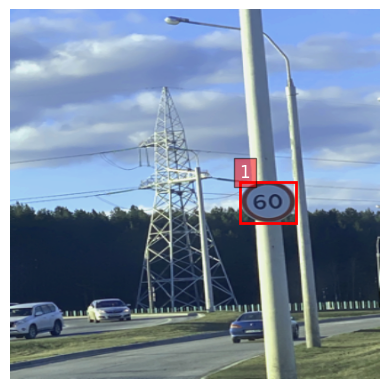

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_dataset_sample(dataset, idx):
    image, target = dataset[idx]

    # Переводим тензор изображения обратно в [0,1]
    if isinstance(image, torch.Tensor):
        image = image.permute(1,2,0).cpu().numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    boxes = target['boxes']
    labels = target['labels']

    for i in range(len(boxes)):
        xmin, ymin, xmax, ymax = boxes[i]

        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        ax.text(xmin, ymin - 5, str(label), color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

visualize_dataset_sample(train_dataset, idx=241)



In [74]:
import torch.nn.functional as F

def compute_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCEWithLogitsLoss()
    ce_loss = nn.CrossEntropyLoss()

    B, _, S, _ = pred.shape
    A = 2
    C = 4

    pred = pred.view(B, A, (5 + C), S, S).permute(0, 1, 3, 4, 2)
    target = target

    obj_mask = target[..., 4] == 1
    noobj_mask = target[..., 4] == 0

    if obj_mask.sum() > 0:
        loss_xy = mse_loss(pred[obj_mask][..., 0:2], target[obj_mask][..., 0:2])
        loss_wh = mse_loss(pred[obj_mask][..., 2:4], target[obj_mask][..., 2:4])
        loss_obj = bce_loss(pred[obj_mask][..., 4], target[obj_mask][..., 4])
        loss_class = ce_loss(pred[obj_mask][..., 5:], target[obj_mask][..., 5:].argmax(dim=-1))
    else:
        loss_xy = torch.tensor(0.0, device=pred.device)
        loss_wh = torch.tensor(0.0, device=pred.device)
        loss_obj = torch.tensor(0.0, device=pred.device)
        loss_class = torch.tensor(0.0, device=pred.device)

    loss_noobj = bce_loss(pred[noobj_mask][..., 4], target[noobj_mask][..., 4])

    loss = lambda_coord * (loss_xy + loss_wh) + loss_obj + lambda_noobj * loss_noobj + loss_class

    return loss

def bbox_iou(box1, anchors):
    inter_w = torch.min(box1[0], anchors[:, 0])
    inter_h = torch.min(box1[1], anchors[:, 1])
    inter_area = inter_w * inter_h

    union_area = (box1[0] * box1[1]) + (anchors[:, 0] * anchors[:, 1]) - inter_area
    return inter_area / (union_area + 1e-6)


def prepare_targets(targets, anchors_26, anchors_13, S_26=26, S_13=13, device='cpu'):
    num_classes = 4
    num_anchors_26 = len(anchors_26)
    num_anchors_13 = len(anchors_13)

    target_26 = torch.zeros((len(targets), num_anchors_26, S_26, S_26, 5 + num_classes), device=device)
    target_13 = torch.zeros((len(targets), num_anchors_13, S_13, S_13, 5 + num_classes), device=device)

    all_anchors = torch.tensor(anchors_26 + anchors_13, device=device)

    for b_idx, target in enumerate(targets):
        boxes = target['boxes']
        labels = target['labels']

        for box_idx in range(boxes.shape[0]):
            xmin, ymin, xmax, ymax = boxes[box_idx]

            cx = (xmin + xmax) / 2 / 416
            cy = (ymin + ymax) / 2 / 416
            w = (xmax - xmin) / 416
            h = (ymax - ymin) / 416

            gt_box = torch.tensor([w, h], device=device)
            ious = bbox_iou(gt_box, all_anchors)

            best_anchor_idx = torch.argmax(ious).item()

            if best_anchor_idx < num_anchors_26:
                anchor_idx = best_anchor_idx
                scale = S_26
                target_map = target_26
            else:
                anchor_idx = best_anchor_idx - num_anchors_26
                scale = S_13
                target_map = target_13

            grid_x = int(cx * scale)
            grid_y = int(cy * scale)

            grid_x = min(grid_x, scale - 1)
            grid_y = min(grid_y, scale - 1)

            if target_map[b_idx, anchor_idx, grid_y, grid_x, 4] == 0:
                target_map[b_idx, anchor_idx, grid_y, grid_x, 0] = cx * scale - grid_x
                target_map[b_idx, anchor_idx, grid_y, grid_x, 1] = cy * scale - grid_y
                target_map[b_idx, anchor_idx, grid_y, grid_x, 2] = w
                target_map[b_idx, anchor_idx, grid_y, grid_x, 3] = h
                target_map[b_idx, anchor_idx, grid_y, grid_x, 4] = 1.0
                target_map[b_idx, anchor_idx, grid_y, grid_x, 5 + labels[box_idx]] = 1.0

    return target_26, target_13


def train_yolo(model, train_loader, val_loader, anchors_26, anchors_13, device, num_epochs=20, patience=5):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for imgs, targets in train_loader:
            imgs = torch.stack(imgs).to(device)
            targets = list(targets)

            preds_13, preds_26 = model(imgs)

            preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
            preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

            target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

            loss_13 = compute_loss(preds_13, target_13)
            loss_26 = compute_loss(preds_26, target_26)

            loss = loss_13 + loss_26

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs = torch.stack(imgs).to(device)
                targets = list(targets)

                preds_13, preds_26 = model(imgs)
                preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
                preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

                target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

                loss_13 = compute_loss(preds_13, target_13)
                loss_26 = compute_loss(preds_26, target_26)

                loss = loss_13 + loss_26
                val_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Validation Loss: {val_loss / len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    return model



In [ ]:
import torch
import torch.nn as nn

class TinyYOLOv3(nn.Module):
    def __init__(self, num_classes=4, anchors_26=2, anchors_13=2):
        super(TinyYOLOv3, self).__init__()

        def conv_bn_lrelu(in_channels, out_channels, kernel_size, stride=1):
            padding = (kernel_size - 1) // 2
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1)
            )

        self.layer1 = conv_bn_lrelu(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.layer2 = conv_bn_lrelu(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.layer3 = conv_bn_lrelu(32, 64, 3)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.layer4 = conv_bn_lrelu(64, 128, 3)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.layer5 = conv_bn_lrelu(128, 256, 3)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.layer6 = conv_bn_lrelu(256, 512, 3)
        self.pool6 = nn.MaxPool2d(2, 2, padding=1)

        self.layer7 = conv_bn_lrelu(512, 1024, 3)

        self.head_13 = nn.Sequential(
            conv_bn_lrelu(1024, 256, 1),
            conv_bn_lrelu(256, 512, 3),
            nn.Conv2d(512, anchors_13 * (5 + num_classes), 1)
        )

        self.conv_up = conv_bn_lrelu(1024, 256, 1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.head_26 = nn.Sequential(
            conv_bn_lrelu(512, 256, 3),
            nn.Conv2d(256, anchors_26 * (5 + num_classes), 1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.pool1(x)

        x = self.layer2(x)
        x = self.pool2(x)

        x = self.layer3(x)
        x = self.pool3(x)

        x = self.layer4(x)
        x = self.pool4(x)

        x = self.layer5(x)
        route = x.clone()
        x = self.pool5(x)

        x = self.layer6(x)

        x = self.layer7(x)

        out_13 = self.head_13(x)
        up = self.conv_up(x)
        up = self.upsample(up)
        merge = torch.cat([up, route], dim=1)
        out_26 = self.head_26(merge)

        return out_13, out_26


In [78]:
import torch.nn.functional as F

def compute_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCEWithLogitsLoss()
    ce_loss = nn.CrossEntropyLoss()

    B, _, S, _ = pred.shape
    A = 2
    C = 4

    pred = pred.view(B, A, (5 + C), S, S).permute(0, 1, 3, 4, 2)
    target = target

    obj_mask = target[..., 4] == 1
    noobj_mask = target[..., 4] == 0

    if obj_mask.sum() > 0:
        loss_xy = mse_loss(pred[obj_mask][..., 0:2], target[obj_mask][..., 0:2])
        loss_wh = mse_loss(pred[obj_mask][..., 2:4], target[obj_mask][..., 2:4])
        loss_obj = bce_loss(pred[obj_mask][..., 4], target[obj_mask][..., 4])
        loss_class = ce_loss(pred[obj_mask][..., 5:], target[obj_mask][..., 5:].argmax(dim=-1))
    else:
        loss_xy = torch.tensor(0.0, device=pred.device)
        loss_wh = torch.tensor(0.0, device=pred.device)
        loss_obj = torch.tensor(0.0, device=pred.device)
        loss_class = torch.tensor(0.0, device=pred.device)

    loss_noobj = bce_loss(pred[noobj_mask][..., 4], target[noobj_mask][..., 4])

    loss = lambda_coord * (loss_xy + loss_wh) + loss_obj + lambda_noobj * loss_noobj + loss_class

    return loss

def bbox_iou(box1, anchors):
    inter_w = torch.min(box1[0], anchors[:, 0])
    inter_h = torch.min(box1[1], anchors[:, 1])
    inter_area = inter_w * inter_h

    union_area = (box1[0] * box1[1]) + (anchors[:, 0] * anchors[:, 1]) - inter_area
    return inter_area / (union_area + 1e-6)


def prepare_targets(targets, anchors_26, anchors_13, S_26=26, S_13=13, device='cpu'):
    num_classes = 4
    num_anchors_26 = len(anchors_26)
    num_anchors_13 = len(anchors_13)

    target_26 = torch.zeros((len(targets), num_anchors_26, S_26, S_26, 5 + num_classes), device=device)
    target_13 = torch.zeros((len(targets), num_anchors_13, S_13, S_13, 5 + num_classes), device=device)

    all_anchors = torch.tensor(anchors_26 + anchors_13, device=device)

    for b_idx, target in enumerate(targets):
        boxes = target['boxes']
        labels = target['labels']

        for box_idx in range(boxes.shape[0]):
            xmin, ymin, xmax, ymax = boxes[box_idx]

            cx = (xmin + xmax) / 2 / 416
            cy = (ymin + ymax) / 2 / 416
            w = (xmax - xmin) / 416
            h = (ymax - ymin) / 416

            gt_box = torch.tensor([w, h], device=device)
            ious = bbox_iou(gt_box, all_anchors)

            best_anchor_idx = torch.argmax(ious).item()

            if best_anchor_idx < num_anchors_26:
                anchor_idx = best_anchor_idx
                scale = S_26
                target_map = target_26
            else:
                anchor_idx = best_anchor_idx - num_anchors_26
                scale = S_13
                target_map = target_13

            grid_x = int(cx * scale)
            grid_y = int(cy * scale)

            grid_x = min(grid_x, scale - 1)
            grid_y = min(grid_y, scale - 1)

            if target_map[b_idx, anchor_idx, grid_y, grid_x, 4] == 0:
                target_map[b_idx, anchor_idx, grid_y, grid_x, 0] = cx * scale - grid_x
                target_map[b_idx, anchor_idx, grid_y, grid_x, 1] = cy * scale - grid_y
                target_map[b_idx, anchor_idx, grid_y, grid_x, 2] = w
                target_map[b_idx, anchor_idx, grid_y, grid_x, 3] = h
                target_map[b_idx, anchor_idx, grid_y, grid_x, 4] = 1.0
                target_map[b_idx, anchor_idx, grid_y, grid_x, 5 + labels[box_idx]] = 1.0

    return target_26, target_13


def train_yolo(model, train_loader, val_loader, anchors_26, anchors_13, device, num_epochs=12, patience=5):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for imgs, targets in train_loader:
            imgs = torch.stack(imgs).to(device)
            targets = list(targets)

            preds_13, preds_26 = model(imgs)

            preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
            preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

            target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

            loss_13 = compute_loss(preds_13, target_13)
            loss_26 = compute_loss(preds_26, target_26)

            loss = loss_13 + loss_26

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs = torch.stack(imgs).to(device)
                targets = list(targets)

                preds_13, preds_26 = model(imgs)
                preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
                preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

                target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

                loss_13 = compute_loss(preds_13, target_13)
                loss_26 = compute_loss(preds_26, target_26)

                loss = loss_13 + loss_26
                val_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Validation Loss: {val_loss / len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    return model


In [79]:
anchors_13 = [(0.0851, 0.0736), (0.2042, 0.1751)]
anchors_26 = [(0.3377, 0.3445), (0.5736, 0.7558)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TinyYOLOv3(num_classes=4, anchors_13=2, anchors_26=2)

train_yolo(
    model=model,
    train_loader=train_loader,
    device=device,
    anchors_13=anchors_13,
    anchors_26=anchors_26,
    val_loader=val_loader
)

[Epoch 1/12] Train Loss: 10.3316
[Epoch 1/12] Validation Loss: 4.1679
[Epoch 2/12] Train Loss: 4.5409
[Epoch 2/12] Validation Loss: 3.8803
[Epoch 3/12] Train Loss: 4.1949
[Epoch 3/12] Validation Loss: 3.5208
[Epoch 4/12] Train Loss: 3.9062
[Epoch 4/12] Validation Loss: 3.1935
[Epoch 5/12] Train Loss: 3.8086
[Epoch 5/12] Validation Loss: 3.6386
[Epoch 6/12] Train Loss: 4.0452
[Epoch 6/12] Validation Loss: 3.4840
[Epoch 7/12] Train Loss: 3.2760
[Epoch 7/12] Validation Loss: 2.8909
[Epoch 8/12] Train Loss: 3.0789
[Epoch 8/12] Validation Loss: 2.7029
[Epoch 9/12] Train Loss: 2.8323
[Epoch 9/12] Validation Loss: 2.9965
[Epoch 10/12] Train Loss: 2.5717
[Epoch 10/12] Validation Loss: 2.6916
[Epoch 11/12] Train Loss: 2.3239
[Epoch 11/12] Validation Loss: 2.2309
[Epoch 12/12] Train Loss: 2.0195
[Epoch 12/12] Validation Loss: 2.0592


TinyYOLOv3(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [ ]:
import numpy as np
import torch
from sklearn.metrics import average_precision_score
from collections import defaultdict

def decode_best_box(pred, anchors, S, device, conf_threshold=0.5):
    B, _, H, W = pred.shape
    A = len(anchors)
    C = 4 

    pred = pred.view(B, A, (5 + C), H, W).permute(0, 1, 3, 4, 2).contiguous()

    boxes = []
    scores = []
    labels = []

    for b in range(B):
        boxes_per_image = []
        scores_per_image = []
        labels_per_image = []

        for a in range(A):
            pred_conf = pred[b, a, :, :, 4].sigmoid()
            pred_cls = pred[b, a, :, :, 5:].softmax(-1)
            pred_box = pred[b, a, :, :, :4]

            mask = pred_conf > conf_threshold

            if mask.sum() == 0:
                continue

            ys, xs = mask.nonzero(as_tuple=True)
            for y, x in zip(ys, xs):
                bx, by, bw, bh = pred_box[y, x]
                cx = (x + bx) / S
                cy = (y + by) / S
                w = bw
                h = bh

                score, label = pred_cls[y, x].max(0)
                final_score = pred_conf[y, x] * score

                boxes_per_image.append([cx, cy, w, h])
                scores_per_image.append(final_score.item())
                labels_per_image.append(label.item())

        boxes.append(boxes_per_image)
        scores.append(scores_per_image)
        labels.append(labels_per_image)

    return boxes, scores, labels

def box_iou_single(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter + 1e-6
    return inter / union

def evaluate_model(model, val_loader,
                   anchors_13, anchors_26,
                   device, conf_threshold=0.5):
    model.eval()

    num_classes = 4
    TP = FP = FN = 0
    all_ious = []

    iou_thresholds = np.arange(0.5, 1.0, 0.05)
    y_true_all = {iou: defaultdict(list) for iou in iou_thresholds}
    y_scores_all = {iou: defaultdict(list) for iou in iou_thresholds}

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = torch.stack(imgs).to(device)
            preds_13, preds_26 = model(imgs)

            boxes_13, scores_13, labels_13 = decode_best_box(
                preds_13, anchors_13, 13, device, conf_threshold)
            boxes_26, scores_26, labels_26 = decode_best_box(
                preds_26, anchors_26, 26, device, conf_threshold)

            B = imgs.size(0)
            for i in range(B):
                boxes  = boxes_13[i]  + boxes_26[i]
                scores = scores_13[i] + scores_26[i]
                labels = labels_13[i] + labels_26[i]
                if not boxes:
                    continue

                best = int(np.argmax(scores))
                pb, ps, pl = boxes[best], scores[best], labels[best]

                px, py, pw, ph = pb
                pred_abs = [
                    (px - pw/2)*416, (py - ph/2)*416,
                    (px + pw/2)*416, (py + ph/2)*416
                ]

                gt_boxes  = targets[i]['boxes']
                gt_labels = targets[i]['labels']
                if len(gt_boxes) == 0:
                    continue

                best_iou = 0; best_j = -1
                for j in range(len(gt_boxes)):
                    iou = box_iou_single(torch.tensor(pred_abs), gt_boxes[j])
                    if iou > best_iou:
                        best_iou, best_j = iou, j
                all_ious.append(best_iou)

                if best_iou >= 0.5 and pl == gt_labels[best_j].item():
                    TP += 1
                else:
                    FP += 1
                    FN += 1

                for iou_thresh in iou_thresholds:
                    is_tp = (best_iou >= iou_thresh) and (pl == gt_labels[best_j].item())
                    y_true_all[iou_thresh][pl].append(int(is_tp))
                    y_scores_all[iou_thresh][pl].append(ps)

    mean_iou = np.mean(all_ious) if all_ious else 0.0
    
    mAPs = []
    for iou_thresh in iou_thresholds:
        APs = []
        for c in range(num_classes):
            y_t = y_true_all[iou_thresh][c]
            y_s = y_scores_all[iou_thresh][c]
            if len(set(y_t)) > 1:
                APs.append(average_precision_score(y_t, y_s))
        mAP = np.mean(APs) if APs else 0.0
        mAPs.append(mAP)

    mAP_50 = mAPs[0]
    mAP_50_95 = np.mean(mAPs)

    print(f"mAP@0.5     : {mAP_50:.4f}")
    print(f"mAP@.50:.95 : {mAP_50_95:.4f}")

In [82]:
evaluate_model(model, val_loader, anchors_13, anchors_26, device)

mAP@0.5  : 0.5391
mAP@.50:.95 : 0.3214


# Общие выводы

* Эталонные модели значительно лучше вашей собственной реализации по обеим метрикам;

* Разница между mAP@0.5 и mAP@0.5-0.95 у эталонных моделей меньше — значит они стабильнее и точнее локализуют объекты;

* Собственные модели явно нуждаются в доработке — возможно, архитектура, обучение, постобработка или аугментации работают неэффективно.